In [292]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, List
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel , Field
load_dotenv()

True

In [293]:
model = ChatOpenAI(model_name="gpt-4o-mini")

class sentiment(BaseModel):
    sentiment: Literal["positive", "negative", "neutral"] = Field(..., description="The sentiment of the review. Can be positive, negative, or neutral.")

structure_model = model.with_structured_output(sentiment)

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

sturcture_model_diagnosis = model.with_structured_output(DiagnosisSchema)    

     

In [294]:
class ReviewReply(TypedDict):
    review: str
    sentiment: Literal["positive", "negative", "neutral"]
    diagnosis: DiagnosisSchema
    reply: str

In [295]:
def find_sentiment(state: ReviewReply) -> ReviewReply:
    review = state['review']
    
    prompt = f"Analyze the sentiment of this review: \"{review}\""
    sentiment_result = structure_model.invoke(prompt)
    
    return {"sentiment": sentiment_result.sentiment}

In [296]:
def check_sentiment(state: ReviewReply) -> Literal["positive_reply", "diagonsis_reply"]:

    if state['sentiment'] == 'positive':
        return 'postive_reply'
    else:
        return 'diagonsis_reply'

In [297]:
def postive_reply(state:ReviewReply) -> ReviewReply:
    
    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n Also, kindly ask the user to leave feedback on our website."""   
    reply = model.invoke(prompt)
     
    return {"reply": reply}

In [298]:
def negative_reply(state:ReviewReply) -> ReviewReply:
    
    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n Also, kindly ask the user to leave feedback on our website."""   
    reply = model.invoke(prompt)
     
    return {"reply": reply}

In [299]:
def diagonsis_reply(state: ReviewReply) -> ReviewReply:
    
    prompt = f"Analyze the review and provide a diagnosis with issue type, tone, and urgency: \"{state['review']}\""
    reply = model.invoke(prompt)
    
    return {"diagnosis": reply}

In [300]:
state = StateGraph(ReviewReply)
state.add_node("find_sentiment",find_sentiment)
state.add_node("positive_reply",postive_reply)
state.add_node("diagonsis_reply",diagonsis_reply)
state.add_node("negative_reply",negative_reply)

state.add_edge(START, "find_sentiment")
state.add_conditional_edges("find_sentiment", check_sentiment)
state.add_edge("positive_reply", END)
state.add_edge("diagonsis_reply", "negative_reply")
state.add_edge("negative_reply", END)

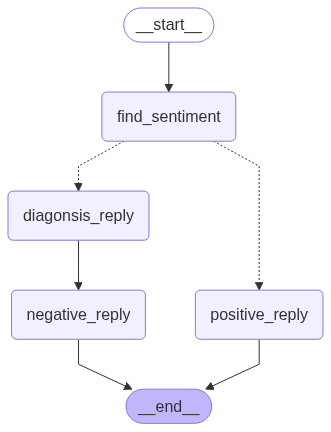

In [301]:
workflow = state.compile()
workflow

In [302]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': AIMessage(content='**Diagnosis:**\n\n- **Issue Type:** Technical Bug / App Functionality\n- **Tone:** Frustrated / Disappointed\n- **Urgency:** High\n\n**Analysis:**\nThe user expresses frustration over a persistent issue with the app that is preventing them from logging in, indicating a critical barrier to accessing the app\'s basic functionality. The mention of the app freezing and the attempted solution (reinstallation) suggests a serious bug that is likely affecting not just this user but potentially others as well. The use of the phrase "unacceptable" highlights the severity of the issue and the user\'s expectation for a reliable experience. Overall, this issue should be prioritized for prompt resolut